# Engage3 Data Challenge

## 1. Create Regional Prices Cross-Tablulation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings

warnings.filterwarnings('ignore')

I will first load the data into separate dataframes from the three separate files provided.

In [2]:
prices = pd.read_csv('prices.csv')
prices.head()

,Auditor ID,Date,Price,Store ID,UPC
0,234,10/18/17,24.95,66999,268588472
1,234,10/27/17,49.71,66999,475245085
2,234,10/20/17,25.75,66999,126967843
3,234,10/23/17,18.81,66999,708930835
4,234,10/23/17,33.32,66999,325885139


In [3]:
auditors = pd.read_csv('auditors.csv')
auditors.head()

,Auditor ID,First,Last,Region
0,234,Sue,Smith,Northern California
1,536,Bob,Smith,Northern California
2,98,Jack,Smith,New York
3,203,Jill,Smith,New York
4,304,Jerry,Johnson,Texas


In [4]:
stores = pd.read_json('stores.json')
stores.head()

,Banner,Region,Store ID
0,Walmart,Northern California,66999
1,Trader Joes,Northern California,4698
2,Safeway,Northern California,39482
3,Whole Foods,Northern California,34957
4,Walmart,New York,12837


In order to bring all the data I need to create the cross-tabulation table in one dataframe, I will create the Banner and Region columns that I need in the prices dataframe and then use layered "for loops" on the price dataframe to check for matches between the Store ID in the prices and stores dataframes and iteratively set the Banner and Region variables in the prices dataframe to their respective value in the stores dataframe when there is a match. This will iterate over each row of the prices dataframe.

In [5]:
prices['Banner'] = np.nan
prices['Region'] = np.nan

for i, store in enumerate(prices['Store ID']):
    for n, store_2 in enumerate(stores['Store ID']):
        if store == store_2:
            prices.loc[i, 'Banner'] = stores.loc[n, 'Banner']
            prices.loc[i, 'Region'] = stores.loc[n, 'Region']

prices.head()

,Auditor ID,Date,Price,Store ID,UPC,Banner,Region
0,234,10/18/17,24.95,66999,268588472,Walmart,Northern California
1,234,10/27/17,49.71,66999,475245085,Walmart,Northern California
2,234,10/20/17,25.75,66999,126967843,Walmart,Northern California
3,234,10/23/17,18.81,66999,708930835,Walmart,Northern California
4,234,10/23/17,33.32,66999,325885139,Walmart,Northern California


In [6]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12315 entries, 0 to 12314
Data columns (total 7 columns):
Auditor ID    12315 non-null int64
Date          12315 non-null object
Price         12315 non-null float64
Store ID      12315 non-null int64
UPC           12315 non-null int64
Banner        11511 non-null object
Region        11511 non-null object
dtypes: float64(1), int64(3), object(3)
memory usage: 673.6+ KB


There is missingness in the Banner and Region columns. This means there was most likely one or more Store ID's in the prices dataframe that were not present in the stores dataframe and therefore did not get matching data. I will do some visualizations to explore what the gaps are.

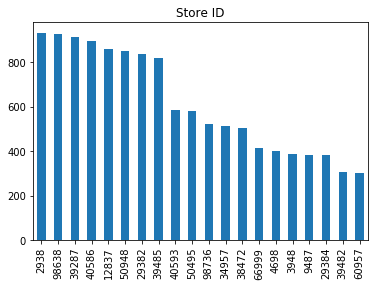

In [7]:
prices['Store ID'].value_counts().plot(kind='bar', title='Store ID')

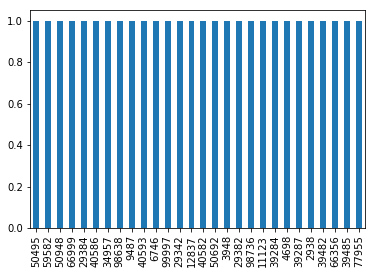

In [8]:
stores['Store ID'].value_counts().plot(kind='bar')

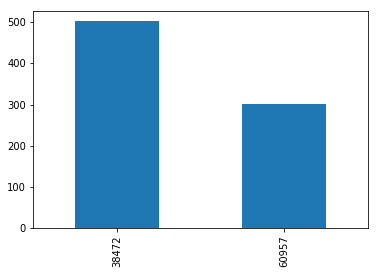

In [9]:
prices[prices.isnull().any(axis=1)]['Store ID'].value_counts().plot(kind='bar')

These are the two Store ID's where there is any missing data. These Store ID's also cannot be found in the stores dataframe taken from the Stores JSON file, explaining why there is no Banner or Region information for these Store ID's. I will check to see which Auditors are in the missing data.

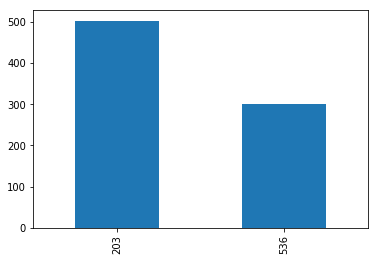

In [10]:
prices[prices.isnull().any(axis=1)]['Auditor ID'].value_counts().plot(kind='bar')

I can at least use the auditors dataframe to fill out the Region information using a similar process as above, but only with the Region column as there is no Banner information in the auditor dataframe to match into the prices dataframe.

In [11]:
# Use the Auditors dataframe to fill in Region information where Store dataframe was lacking information.

for i, auditor in enumerate(prices['Auditor ID']):
    for n, auditor_2 in enumerate(auditors['Auditor ID']):
        if auditor == auditor_2:
            prices.loc[i, 'Region'] = auditors.loc[n, 'Region']

prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12315 entries, 0 to 12314
Data columns (total 7 columns):
Auditor ID    12315 non-null int64
Date          12315 non-null object
Price         12315 non-null float64
Store ID      12315 non-null int64
UPC           12315 non-null int64
Banner        11511 non-null object
Region        12315 non-null object
dtypes: float64(1), int64(3), object(3)
memory usage: 673.6+ KB


In [12]:
prices = prices.drop(columns=['Auditor ID', 'Date', 'Store ID'])

In [13]:
table = pd.pivot_table(prices, values='Price', index=['Banner', 'UPC'], columns='Region')

table.head()

Region            Kansas  New York  Northern California  Texas
Banner  UPC                                                   
Safeway 11873171     NaN      6.09                  NaN   5.19
        15052612   53.99       NaN                  NaN  54.49
        16482322   17.89       NaN                  NaN  18.09
        16729338    7.99      9.39                  NaN   8.09
        16829288    3.59      4.19                  NaN   3.59

In [14]:
table.to_csv('Engage3_Challenge.csv')

## 2. Anamolies Detection 

The first problem with the data, which I had already found in the data loading, is that there were 804 price datapoints whose Store ID's were not in the Store information JSON file. While I was able to retrieve the region information by matching the Auditor ID with the Auditor information in the provided Auditor CSV, this meant I was still lacking the Banner information for those 804 price datapoints. The cross-tabs for regional prices are broken down by both Banner and UPC, so prices with missing banner information distorts the data.

I will now perform exploratory data analysis to find anything else in the data that is concerning, beginnig with summary statistics of the regional price distributions.

In [15]:
table.describe()

Region,Kansas,New York,Northern California,Texas
count,3087.000000,3331.000000,1328.000000,3765.000000
mean,21.390198,31.368157,35.471310,30.084550
std,18.610435,17.436303,19.717375,16.709557
min,0.690000,0.590000,0.690000,0.590000
25%,1.990000,17.020000,19.090000,16.290000
50%,17.690000,31.090000,34.990000,29.840000
75%,37.490000,45.590000,51.597500,44.060000
max,59.990000,70.090000,74.490000,63.890000


Northern California has significantly less price information than the other regions, with only 1328 price datapoints compared to over 3,000 for the other three regions. While some of the Missing Banner data came from the Northern California region (based on the Auditor information) more of it came from the New York region, so that is not an adequate explanation for the large gap in price data. I would judge Northern California to either need a significant push for more price data, or there is something wrong with the reporting that is being done where the prices are not being entered correctly.

The other anamoly that sticks out to me is the distribution of prices for the Kansas region. The 25th percentile of prices is extremely lower than the other three regions. I will create basic histograms of the four regions' price distributions for visual analysis of this problem.

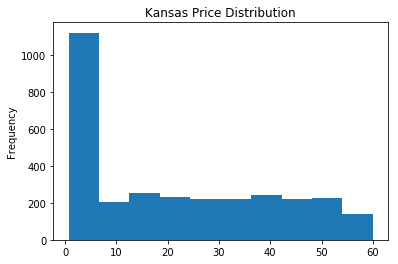

In [16]:
table['Kansas'].plot(kind='hist', title='Kansas Price Distribution')

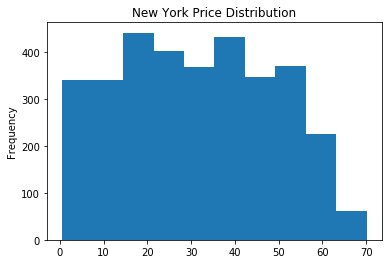

In [17]:
table['New York'].plot(kind='hist', title='New York Price Distribution')

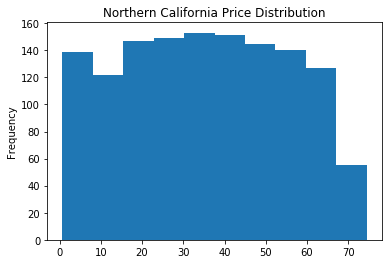

In [18]:
table['Northern California'].plot(kind='hist', title='Northern California Price Distribution')

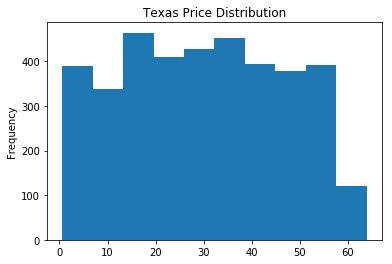

In [19]:
table['Texas'].plot(kind='hist', title='Texas Price Distribution')

As I suspected, there is extreme left skewness to the prices in the Kansas price data, while the three other regions are fairly evenly distributed. There is a problem that needs to be investigated with the reporting of price data by the Kansas auditors, Mike Johnson and Dave Johnson.

I will return to the prices dataframe to find the average prices grouped by Banner and Region for more analysis.

In [20]:
prices.groupby(['Banner', 'Region'])['Price'].mean()

Banner       Region             
Safeway      Kansas                 30.694151
             New York               35.292941
             Texas                  30.619833
Trader Joes  Kansas                 29.201024
             New York               30.521937
             Northern California    34.376035
             Texas                  29.321849
Walmart      Kansas                 27.646769
             New York               28.427648
             Northern California    32.854515
             Texas                  27.958877
Wegmans      Kansas                 30.276889
             New York               30.885284
             Texas                  30.121931
Whole Foods  Kansas                  1.989452
             New York               33.834301
             Northern California    38.417573
             Texas                  32.823461
Name: Price, dtype: float64

General trends hold with most of the data: Northern California average prices for each Banner are highest. New York is next highest, though only slightly higher than Texas and Kansas, and Texas and Kansas are fairly similar. Store Banner trends can also be found. Whole Foods is most expensive in each region (save for the Kansas locations - more on that problem later). Walmart is the cheapest store in each region. Interestingly, Wegmans has very little regional average price differences.

However, we find the two main problems we have already detected distilled even further. 
1. Northern California has no prices whatsoever reported for Safeway or Wegmans (Wegmans probably does not exist in Northern California based on my knowledge, but Safeway definitely does). This signals a reporting error somewhere along the way for the Northern California auditors, and explains our massive gap between the amount of price datapoints in Northern California compared to all other regions.
2. The Whole Foods in Kansas have an incredibly low price average of just under 2 dollars. The previously discovered Kansas price distribution skewness must be attributed to the Whole Foods price auditing in Kansas. There is either massive user error or system failure that is reporting almost all UPC prices to be 1.99 at the Kansas region Whole Foods.

These two problems, along with the first problem during data loading of having two Store ID's that had no reported Banner information, are what I would report as the issues with the datasets.